# Imports

In [464]:
import string

In [465]:
import numpy as np

In [466]:
import pandas as pd

In [467]:
import matplotlib.pyplot as plt
import seaborn as sns

In [468]:
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, ExtraTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer, OneHotEncoder, StandardScaler, MaxAbsScaler, Normalizer, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD

In [469]:
from scipy.stats import randint, uniform

# Functions

In [470]:
def inspect_df(df : pd.DataFrame):
    """
    Display basic structural information about a DataFrame.

    This function prints the number of rows and columns, checks for
    missing values, and displays the data types of each feature.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to be inspected.

    Returns
    -------
    None
        This function does not return any value. It prints
        summary information to the console.

    Notes
    -----
    - If no missing values are present, the function explicitly
      prints that there are zero null values.
    - If missing values exist, the function prints the number
      of null values for each column.
    - Feature data types are displayed using `df.dtypes`.
    """
    print(f'Rows:       {df.shape[0]}')
    print(f'Columns:    {df.shape[1]}')
    print("-" * 30)

    null_values = df.isna().sum()
    if (null_values.sum() == 0):
        print('Null values: 0')
    else:
        print('Null values:')
        print(null_values)
    
    print("-" * 30)
    print('Feature data types:')
    print(df.dtypes)
    print("")

In [471]:
def check_balance(df : pd.DataFrame, target_col : str):
    """
    Check the class distribution of a target column in a dataset.

    This function computes the percentage distribution of each class
    in the specified target column and prints the results. It also
    displays the ideal percentage share per class for a perfectly
    balanced dataset.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame containing the dataset.
    target_col : str
        Name of the target column whose class distribution
        needs to be evaluated.

    Returns
    -------
    None
        This function does not return any value. It prints
        the class distribution and balance information.

    Notes
    -----
    - Percentages are computed using normalized value counts
      and rounded to two decimal places.
    - The dataset can be considered balanced if the class
      percentages are close to the ideal equal share
      (100 / number_of_classes).
    - The function assumes that `target_col` exists in `df`.
    """
    value_counts = (df[target_col].value_counts(normalize=True) * 100).round(2)
    ideal_share = 100 / len(value_counts)
    
    print(f'Value counts for {target_col}:')
    print(value_counts)
    print("-" * 30)
    print(f'The dataset is balanced if the value counts are close to {ideal_share:.2f}%')

In [472]:
def plot_scatter(df : pd.DataFrame, x_feature : str, y_feature : str):
    """
    Generate a scatter plot for two selected features from a DataFrame.

    This function creates a scatter plot using the specified columns
    as x and y axes and displays the plot.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame containing the data to be plotted.
    x_feature : str
        Name of the column to be used as the x-axis.
    y_feature : str
        Name of the column to be used as the y-axis.

    Returns
    -------
    None
        This function does not return any value. It displays the plot.

    Notes
    -----
    - The function assumes that both `x_feature` and `y_feature`
      exist in the provided DataFrame.
    - No additional styling or customization is applied to the plot.
    """
    plt.scatter(df[x_feature], df[y_feature])
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.show()

In [473]:
def evaluate_classifier(model, x_test, y_test, title: str, f1_average: str = 'binary', f1_pos_label=1):
    """
    Evaluate the performance of a classification model on a test dataset.

    This function computes Accuracy and F1-score, prints the results,
    and displays the confusion matrix normalized by rows.

    Parameters
    ----------
    model : estimator
        A trained classification model implementing the `predict` method.
    x_test : array-like
        Feature matrix of the test dataset.
    y_test : array-like
        True labels corresponding to `x_test`.
    title : str
        Descriptive title to display in the output and on the confusion matrix plot.
    f1_average : str, default='binary'
        Averaging method used to compute the F1-score.
        Common options include: 'binary', 'micro', 'macro', 'weighted'.
    f1_pos_label : int or str, default=1
        The label considered as the positive class when `f1_average='binary'`.

    Returns
    -------
    y_pred : array-like
        Predicted labels generated by the model on `x_test`.

    Notes
    -----
    - The confusion matrix is displayed normalized by rows (`normalize='true'`),
      meaning values represent proportions relative to the true class.
    - Metrics are printed with four decimal places.
    """
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average=f1_average, pos_label=f1_pos_label)

    print("")
    print(f"{title.title()}:")
    print(f"Accuracy:                   {accuracy:.4f}")
    print(f"F1 score ({f1_average}):        {f1:.4f}")

    disp = ConfusionMatrixDisplay.from_predictions(
        y_pred, y_test,
        cmap=plt.cm.Blues, 
        normalize='true'    # 'true' normalize on rows
    )
    disp.ax_.set_title(title.title())
    plt.show()

    return y_pred

In [474]:
def evaluate_regressor(model, x_test, y_test):
    """
    Evaluate the performance of a regression model on a test dataset.

    This function generates predictions using the provided model and
    computes common regression metrics: MAE, MSE, MSLE (if applicable),
    and R² score. The results are printed to the console.

    Parameters
    ----------
    model : estimator
        A trained regression model implementing the `predict` method.
    x_test : array-like
        Feature matrix of the test dataset.
    y_test : array-like
        True target values corresponding to `x_test`.

    Returns
    -------
    y_pred : array-like
        Predicted values generated by the model on `x_test`.

    Notes
    -----
    - MAE (Mean Absolute Error) measures the average absolute difference
      between true and predicted values.
    - MSE (Mean Squared Error) penalizes larger errors more heavily.
    - MSLE (Mean Squared Logarithmic Error) is computed only if all true
      and predicted values are greater than -1. Otherwise, it is not
      applicable.
    - R² score is bounded in the interval (-∞, 1]. Values below 0
      indicate that the model performs worse than a baseline model
      predicting the mean target value.
    """
    y_pred = model.predict(x_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    if (y_test > -1).all() & (y_pred > -1).all():
        msle = mean_squared_log_error(y_test, y_pred)
    else:
        msle = "N/A (y_test contiene valori <= -1)"
    r2 = r2_score(y_test, y_pred)

    print("")
    print(f"MAE:    {mae}")
    print(f"MSE:    {mse}")
    print(f"MSLE:   {msle}")
    print(f"R2:     {r2}")
    print("")
    print("Remember: R2 score is in [-inf, 1]. R2<0 --> BAD MODEL.")

    return y_pred

In [475]:
def get_categorical_features(df : pd.DataFrame):
    return df.select_dtypes(include=['object']).columns

In [476]:
def get_k_correlated(df : pd.DataFrame, y_name : str, k : int, abs : bool, ascending : bool):
    if (abs):
        y_corr = df.corr()[y_name].abs().sort_values(ascending=ascending)
    else:
        y_corr = df.corr()[y_name].sort_values(ascending=ascending)
    return y_corr[1:(k+1)].index

In [477]:
def pfi(model, x_test, y_test):
    pfi = permutation_importance(model, x_test, y_test, n_jobs=-1)
    fig, ax = plt.subplots()
    pd.Series(pfi['importances_mean']).plot.bar(yerr=pfi['importances_std'], ax=ax)
    ax.set_title("Permutation Feature Importance")
    ax.set_ylabel('Importance')
    fig.tight_layout()
    plt.show()

In [478]:
def clean_text(text : str):
    text = text.lower()
    text = text.replace('\n', ' ').replace('\t', ' ').replace('\r', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split())
    return text

# Exam

In [479]:
backup = pd.read_csv('./dataset.csv', sep=',')
df = backup.copy()
df.head()

,ID,year,Gender,approv_in_adv,loan_type,loan_purpose,open_credit,business_or_commercial,loan_amount,rate_of_interest,...,occupancy_type,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,Region,Status
0,24890,2019,Sex Not Available,nopre,type1,p1,nopc,nob/c,116500,NaN,...,pr,1U,1740.0,EXP,758.0,CIB,25-34,to_inst,south,0
1,24891,2019,Male,nopre,type2,p1,nopc,b/c,206500,NaN,...,pr,1U,4980.0,EQUI,552.0,EXP,55-64,to_inst,North,1
2,24892,2019,Male,pre,type1,p1,nopc,nob/c,406500,4.56,...,pr,1U,9480.0,EXP,834.0,CIB,35-44,to_inst,south,1
3,24893,2019,Male,nopre,type1,p4,nopc,nob/c,456500,4.25,...,pr,1U,11880.0,EXP,587.0,CIB,45-54,not_inst,North,0
4,24894,2019,Joint,pre,type1,p1,nopc,nob/c,696500,4.00,...,pr,1U,10440.0,CRIF,602.0,EXP,25-34,not_inst,North,0


In [480]:
inspect_df(df)

Rows:       21944
Columns:    24
------------------------------
Null values:
ID                              0
year                            0
Gender                          0
approv_in_adv                 131
loan_type                       0
loan_purpose                   17
open_credit                     0
business_or_commercial          0
loan_amount                     0
rate_of_interest             5347
term                            9
lump_sum_payment                0
property_value               2242
construction_type               1
occupancy_type                  1
total_units                     1
income                       1318
credit_type                     1
Credit_Score                    1
co-applicant_credit_type        1
age                            27
submission_of_application      27
Region                          1
Status                          0
dtype: int64
------------------------------
Feature data types:
ID                             int64
year  

In [481]:
check_balance(df, 'Status')

Value counts for Status:
Status
1    50.19
0    49.81
Name: proportion, dtype: float64
------------------------------
The dataset is balanced if the value counts are close to 50.00%


In [482]:
df['ratio'] = df['loan_amount'] / df['property_value']
df.head()

,ID,year,Gender,approv_in_adv,loan_type,loan_purpose,open_credit,business_or_commercial,loan_amount,rate_of_interest,...,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,Region,Status,ratio
0,24890,2019,Sex Not Available,nopre,type1,p1,nopc,nob/c,116500,NaN,...,1U,1740.0,EXP,758.0,CIB,25-34,to_inst,south,0,0.987288
1,24891,2019,Male,nopre,type2,p1,nopc,b/c,206500,NaN,...,1U,4980.0,EQUI,552.0,EXP,55-64,to_inst,North,1,NaN
2,24892,2019,Male,pre,type1,p1,nopc,nob/c,406500,4.56,...,1U,9480.0,EXP,834.0,CIB,35-44,to_inst,south,1,0.800197
3,24893,2019,Male,nopre,type1,p4,nopc,nob/c,456500,4.25,...,1U,11880.0,EXP,587.0,CIB,45-54,not_inst,North,0,0.693769
4,24894,2019,Joint,pre,type1,p1,nopc,nob/c,696500,4.00,...,1U,10440.0,CRIF,602.0,EXP,25-34,not_inst,North,0,0.918865


In [483]:
df.groupby('total_units')['ratio'].mean()

total_units
1U    0.732230
2U    0.612850
3U    0.586999
4U    0.607033
Name: ratio, dtype: float64

In [484]:
df['age'].unique()

<StringArray>
['25-34', '55-64', '35-44', '45-54', '65-74', '>74', '<25', nan]
Length: 8, dtype: str

In [485]:
more_than_55 = df.loc[(df['age'] == '55-64') | (df['age'] == '65-74') | (df['age'] == '>74'), :]
more_than_55['income'] = pd.cut(more_than_55['income'], bins=5)
more_than_55['Credit_Score'] = pd.cut(more_than_55['Credit_Score'], bins=5)
pivot = ((more_than_55.pivot_table(index=['income'], columns=['Credit_Score'], values=['Status'], aggfunc='count') / more_than_55['income'].count()) * 100).round(2)
pivot

Status                                \
Credit_Score         (499.6, 580.0] (580.0, 660.0] (660.0, 740.0]   
income                                                              
(-146.22, 29244.0]            19.84          19.20          20.19   
(29244.0, 58488.0]             0.11           0.12           0.06   
(58488.0, 87732.0]             0.05            NaN           0.02   
(116976.0, 146220.0]            NaN           0.01            NaN   

                                                    
Credit_Score         (740.0, 820.0] (820.0, 900.0]  
income                                              
(-146.22, 29244.0]            19.87          20.20  
(29244.0, 58488.0]             0.10           0.11  
(58488.0, 87732.0]             0.06           0.05  
(116976.0, 146220.0]           0.01            NaN

In [486]:
df['occupancy_type'].unique()

<StringArray>
['pr', 'sr', 'ir', nan]
Length: 4, dtype: str

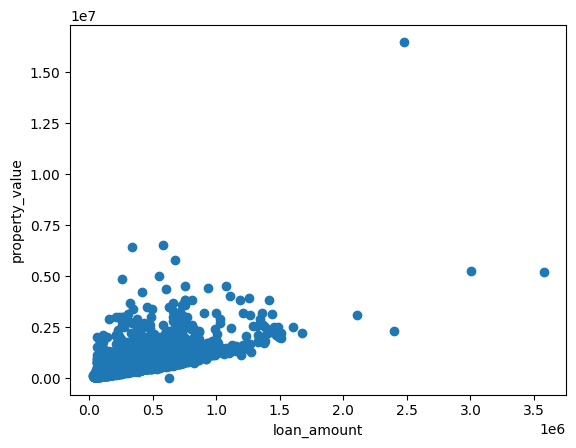

In [487]:
plot_scatter(df.loc[df['occupancy_type'] == 'pr', :], 'loan_amount', 'property_value')

In [488]:
df = backup.copy()
df.head()

,ID,year,Gender,approv_in_adv,loan_type,loan_purpose,open_credit,business_or_commercial,loan_amount,rate_of_interest,...,occupancy_type,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,Region,Status
0,24890,2019,Sex Not Available,nopre,type1,p1,nopc,nob/c,116500,NaN,...,pr,1U,1740.0,EXP,758.0,CIB,25-34,to_inst,south,0
1,24891,2019,Male,nopre,type2,p1,nopc,b/c,206500,NaN,...,pr,1U,4980.0,EQUI,552.0,EXP,55-64,to_inst,North,1
2,24892,2019,Male,pre,type1,p1,nopc,nob/c,406500,4.56,...,pr,1U,9480.0,EXP,834.0,CIB,35-44,to_inst,south,1
3,24893,2019,Male,nopre,type1,p4,nopc,nob/c,456500,4.25,...,pr,1U,11880.0,EXP,587.0,CIB,45-54,not_inst,North,0
4,24894,2019,Joint,pre,type1,p1,nopc,nob/c,696500,4.00,...,pr,1U,10440.0,CRIF,602.0,EXP,25-34,not_inst,North,0


In [489]:
df = df.drop(columns='ID')
df.head()

,year,Gender,approv_in_adv,loan_type,loan_purpose,open_credit,business_or_commercial,loan_amount,rate_of_interest,term,...,occupancy_type,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,Region,Status
0,2019,Sex Not Available,nopre,type1,p1,nopc,nob/c,116500,NaN,360.0,...,pr,1U,1740.0,EXP,758.0,CIB,25-34,to_inst,south,0
1,2019,Male,nopre,type2,p1,nopc,b/c,206500,NaN,360.0,...,pr,1U,4980.0,EQUI,552.0,EXP,55-64,to_inst,North,1
2,2019,Male,pre,type1,p1,nopc,nob/c,406500,4.56,360.0,...,pr,1U,9480.0,EXP,834.0,CIB,35-44,to_inst,south,1
3,2019,Male,nopre,type1,p4,nopc,nob/c,456500,4.25,360.0,...,pr,1U,11880.0,EXP,587.0,CIB,45-54,not_inst,North,0
4,2019,Joint,pre,type1,p1,nopc,nob/c,696500,4.00,360.0,...,pr,1U,10440.0,CRIF,602.0,EXP,25-34,not_inst,North,0


In [490]:
df = df.dropna()
inspect_df(df)

Rows:       15333
Columns:    23
------------------------------
Null values: 0
------------------------------
Feature data types:
year                           int64
Gender                           str
approv_in_adv                    str
loan_type                        str
loan_purpose                     str
open_credit                      str
business_or_commercial           str
loan_amount                    int64
rate_of_interest             float64
term                         float64
lump_sum_payment                 str
property_value               float64
construction_type                str
occupancy_type                   str
total_units                      str
income                       float64
credit_type                      str
Credit_Score                 float64
co-applicant_credit_type         str
age                              str
submission_of_application        str
Region                           str
Status                         int64
dtype: object



In [491]:
cat_features = get_categorical_features(df)
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df[cat_features] = oe.fit_transform(df[cat_features])
df.head()

/tmp/ipykernel_3287/3351726568.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  return df.select_dtypes(include=['object']).columns


,year,Gender,approv_in_adv,loan_type,loan_purpose,open_credit,business_or_commercial,loan_amount,rate_of_interest,term,...,occupancy_type,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,Region,Status
2,2019,2.0,1.0,0.0,0.0,0.0,1.0,406500,4.56,360.0,...,1.0,0.0,9480.0,2.0,834.0,0.0,1.0,1.0,3.0,1
3,2019,2.0,0.0,0.0,3.0,0.0,1.0,456500,4.25,360.0,...,1.0,0.0,11880.0,2.0,587.0,0.0,2.0,0.0,0.0,0
4,2019,1.0,1.0,0.0,0.0,0.0,1.0,696500,4.00,360.0,...,1.0,0.0,10440.0,1.0,602.0,1.0,0.0,0.0,0.0,0
5,2019,1.0,1.0,0.0,0.0,0.0,1.0,706500,3.99,360.0,...,1.0,0.0,10080.0,2.0,864.0,1.0,1.0,0.0,0.0,1
6,2019,1.0,1.0,0.0,2.0,0.0,1.0,346500,4.50,360.0,...,1.0,0.0,5040.0,2.0,860.0,1.0,3.0,1.0,0.0,1


In [492]:
inspect_df(df)

Rows:       15333
Columns:    23
------------------------------
Null values: 0
------------------------------
Feature data types:
year                           int64
Gender                       float64
approv_in_adv                float64
loan_type                    float64
loan_purpose                 float64
open_credit                  float64
business_or_commercial       float64
loan_amount                    int64
rate_of_interest             float64
term                         float64
lump_sum_payment             float64
property_value               float64
construction_type            float64
occupancy_type               float64
total_units                  float64
income                       float64
credit_type                  float64
Credit_Score                 float64
co-applicant_credit_type     float64
age                          float64
submission_of_application    float64
Region                       float64
Status                         int64
dtype: object



In [493]:
X, y = df.drop(columns='Status'), df['Status']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)


Extra Tree:
Accuracy:                   0.5021
F1 score (binary):        0.5027


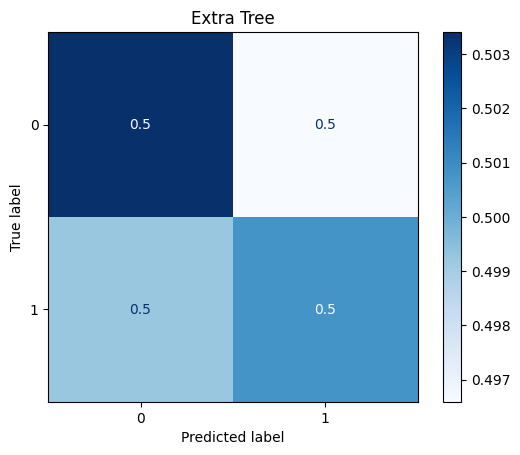


K Neighbors:
Accuracy:                   0.4930
F1 score (weighted):        0.4928


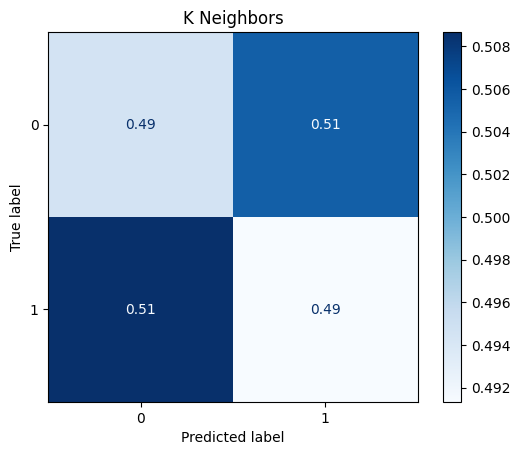


Dummy:
Accuracy:                   0.5013
F1 score (binary):        0.0000


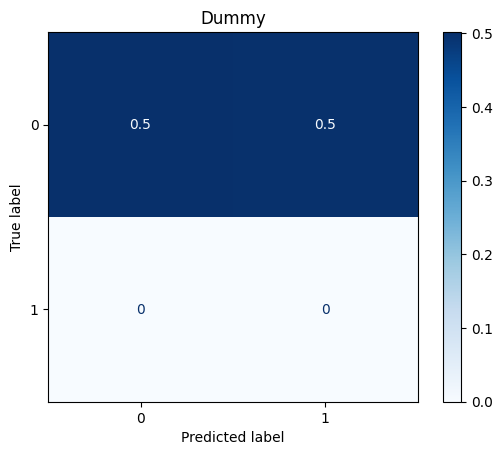

array([0, 0, 0, ..., 0, 0, 0], shape=(3834,))

In [494]:
xt = ExtraTreeClassifier()
xt.fit(x_train, y_train)
evaluate_classifier(xt, x_test, y_test, 'extra tree')

kn = KNeighborsClassifier()
kn.fit(x_train, y_train)
evaluate_classifier(kn, x_test, y_test, 'k neighbors', f1_average='weighted')

dc = DummyClassifier()
dc.fit(x_train, y_train)
evaluate_classifier(dc, x_test, y_test, 'dummy')

In [495]:
print(f'Extra Tree:     {cross_val_score(ExtraTreeClassifier(), X, y, cv=10, scoring='f1', n_jobs=-1).mean()}')
print(f'K Neighbors:    {cross_val_score(KNeighborsClassifier(), X, y, cv=10, scoring='f1_weighted', n_jobs=-1).mean()}')
print(f'Dummy:          {cross_val_score(DummyClassifier(), X, y, cv=10, scoring='f1', n_jobs=-1).mean()}')

Extra Tree:     0.5029877174931474
K Neighbors:    0.4987861033699241
Dummy:          0.0


In [496]:
df.head()

,year,Gender,approv_in_adv,loan_type,loan_purpose,open_credit,business_or_commercial,loan_amount,rate_of_interest,term,...,occupancy_type,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,Region,Status
2,2019,2.0,1.0,0.0,0.0,0.0,1.0,406500,4.56,360.0,...,1.0,0.0,9480.0,2.0,834.0,0.0,1.0,1.0,3.0,1
3,2019,2.0,0.0,0.0,3.0,0.0,1.0,456500,4.25,360.0,...,1.0,0.0,11880.0,2.0,587.0,0.0,2.0,0.0,0.0,0
4,2019,1.0,1.0,0.0,0.0,0.0,1.0,696500,4.00,360.0,...,1.0,0.0,10440.0,1.0,602.0,1.0,0.0,0.0,0.0,0
5,2019,1.0,1.0,0.0,0.0,0.0,1.0,706500,3.99,360.0,...,1.0,0.0,10080.0,2.0,864.0,1.0,1.0,0.0,0.0,1
6,2019,1.0,1.0,0.0,2.0,0.0,1.0,346500,4.50,360.0,...,1.0,0.0,5040.0,2.0,860.0,1.0,3.0,1.0,0.0,1


In [497]:
# Female = 0, Male = 2
women = x_test['Gender'] == 0.0
men = x_test['Gender'] == 2.0
print('Extra Tree:')
print(f'Men:    {((xt.predict(x_test[men]).sum() / x_test['Gender'].count()) * 100).round(2)}')
print(f'Women:  {((xt.predict(x_test[women]).sum() / x_test['Gender'].count()) * 100).round(2)}')
print('K Neighbors:')
print(f'Men:    {((kn.predict(x_test[men]).sum() / x_test['Gender'].count()) * 100).round(2)}')
print(f'Women:  {((kn.predict(x_test[women]).sum() / x_test['Gender'].count()) * 100).round(2)}')

Extra Tree:
Men:    13.2
Women:  9.99
K Neighbors:
Men:    14.19
Women:  8.84


In [498]:
correlation = df['Status']
correlation = pd.concat([correlation, df[get_k_correlated(df, 'Status', 2, abs=False, ascending=False)]], axis=1)
correlation = pd.concat([correlation, df[get_k_correlated(df, 'Status', 2, abs=False, ascending=True)]], axis=1)
correlation

,Status,loan_type,open_credit,business_or_commercial,loan_amount
2,1,0.0,0.0,1.0,406500
3,0,0.0,0.0,1.0,456500
4,0,0.0,0.0,1.0,696500
5,1,0.0,0.0,1.0,706500
6,1,0.0,0.0,1.0,346500
...,...,...,...,...,...
21935,1,0.0,0.0,1.0,596500
21937,1,0.0,0.0,1.0,656500
21939,1,0.0,0.0,1.0,146500
21940,0,1.0,0.0,0.0,286500


In [499]:
X, y = correlation.drop(columns='Status'), correlation['Status']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)


Extra Tree - Most Correlated:
Accuracy:                   0.5097
F1 score (binary):        0.5162


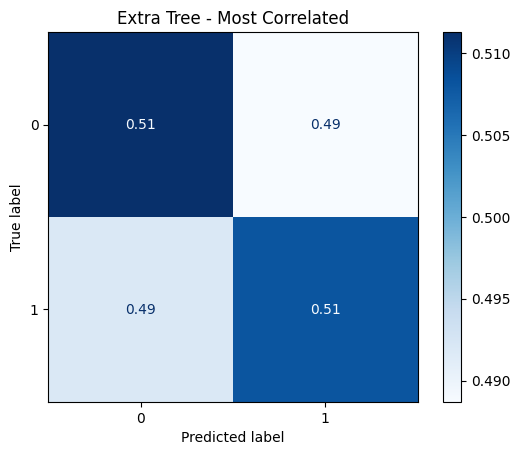

array([1, 0, 0, ..., 0, 1, 1], shape=(3834,))

In [500]:
xt = ExtraTreeClassifier()
xt.fit(x_train, y_train)
evaluate_classifier(xt, x_test, y_test, 'Extra tree - most correlated')

In [501]:
X, y = df.drop(columns='Status'), df['Status']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)


Extra Tree - Optimum Parameters:
Accuracy:                   0.4940
F1 score (binary):        0.4929


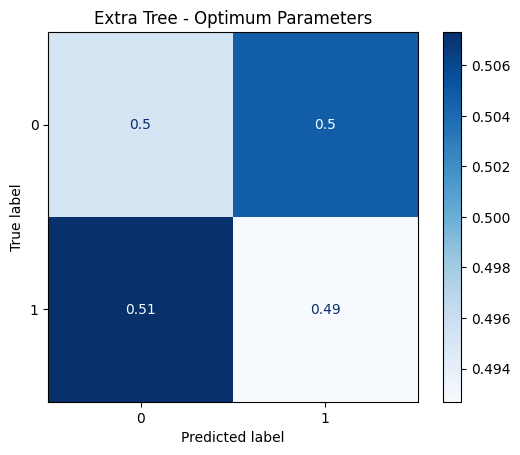

array([1, 0, 0, ..., 1, 1, 0], shape=(3834,))

In [502]:
parameters = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth' : [30, 40, 50, 60, 70, 80]
}

gscv = GridSearchCV(ExtraTreeClassifier(), parameters, cv=10, n_jobs=-1)
gscv.fit(x_train, y_train)
evaluate_classifier(gscv, x_test, y_test, 'Extra tree - optimum parameters')


Pipeline 1:
Accuracy:                   0.5010
F1 score (binary):        0.5073


/home/mattia/miniconda3/envs/big-data/lib/python3.14/site-packages/sklearn/preprocessing/_discretization.py:304: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


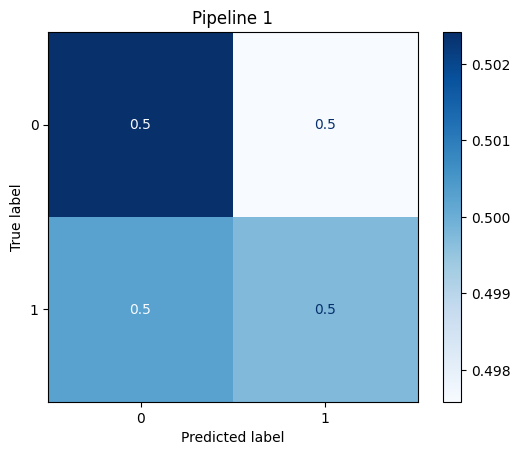

array([1, 1, 0, ..., 1, 1, 1], shape=(3834,))

In [503]:
preprocessor = ColumnTransformer(transformers=[
    ('binning', KBinsDiscretizer(n_bins=7), ['income', 'loan_amount']),
    ('scale', StandardScaler(), ['Credit_Score'])
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ExtraTreeClassifier())
])

pipeline.fit(x_train, y_train)
evaluate_classifier(pipeline, x_test, y_test, 'pipeline 1')


Pipeline 2:
Accuracy:                   0.4974
F1 score (binary):        0.4936


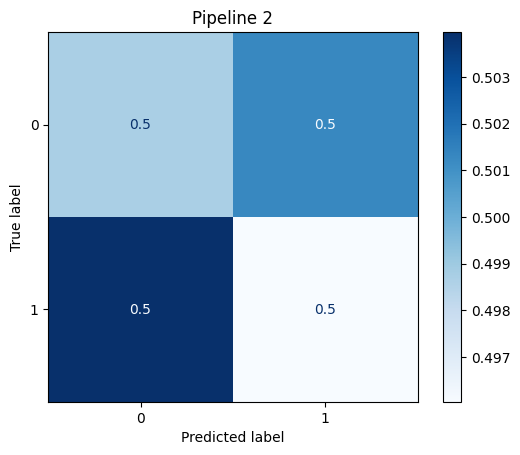

array([0, 1, 0, ..., 0, 1, 1], shape=(3834,))

In [504]:
preprocessor = ColumnTransformer(transformers=[
    ('binning', KBinsDiscretizer(n_bins=7, quantile_method='averaged_inverted_cdf'), ['income', 'loan_amount']),
    ('scale', StandardScaler(), ['Credit_Score'])
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dim_red', TruncatedSVD()),
    ('model', ExtraTreeClassifier())
])

parameters = {
    'dim_red__n_components' : [5, 6, 7, 8, 9, 10, 11, 12],
    'model__criterion' : ['gini', 'entropy', 'log_loss'],
    'model__max_depth' : [30, 40, 50, 60, 70, 80]
}

gscv = GridSearchCV(pipeline, parameters, cv=10, n_jobs=-1)
gscv.fit(x_train, y_train)
evaluate_classifier(gscv, x_test, y_test, 'pipeline 2')